In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


from datetime import datetime

# MLP

In [39]:
# Load and clean data
df = pd.read_csv("Input Data.csv")
df = df[df['Row Labels'] != 'Grand Total']
df['Row Labels'] = pd.to_datetime(df['Row Labels'])

for col in ['reservoir_gwh', 'reservoir_inflows_gwh', 'spot_price_copkwh']:
    df[col] = df[col].str.replace(',', '').astype(float)

# Create multiple lag features
for lag in [1, 3, 7]:
    df[f'spot_lag_{lag}'] = df['spot_price_copkwh'].shift(lag)

# Drop rows with any NaNs from lag creation or original features
required_columns = ['reservoir_gwh', 'reservoir_inflows_gwh', 'spot_price_copkwh'] + [f'spot_lag_{lag}' for lag in [1, 3, 7]]
df = df.dropna(subset=required_columns)

# Add year column for time-based splitting
df['year'] = df['Row Labels'].dt.year
train_df = df[(df['year'] >= 2020) & (df['year'] <= 2023)]
test_df = df[df['year'] == 2024]

# Define feature set with multiple lags
feature_cols = ['reservoir_gwh', 'reservoir_inflows_gwh', 'spot_lag_1', 'spot_lag_3', 'spot_lag_7']

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[feature_cols])
y_train = scaler_y.fit_transform(train_df[['spot_price_copkwh']])
X_test = scaler_X.transform(test_df[feature_cols])
y_test = scaler_y.transform(test_df[['spot_price_copkwh']])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Update DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Neural Network Model
class EnergyPricePredictor(nn.Module):
    def __init__(self):
        super(EnergyPricePredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 16),  # update input size here
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x)

model = EnergyPricePredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

# Evaluate model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    predictions_rescaled = scaler_y.inverse_transform(predictions)
    y_test_rescaled = scaler_y.inverse_transform(y_test)

# Print first n predictions vs actuals
print("First n predictions vs actual values for 2025:")
for pred, actual in zip(predictions_rescaled[:10], y_test_rescaled[:10]):
    print(f"Predicted: {pred[0]:.2f}, Actual: {actual[0]:.2f}, Difference: {np.abs(pred[0] - actual[0]):.2f}")


First n predictions vs actual values for 2025:
Predicted: 176.83, Actual: 222.18, Difference: 45.34
Predicted: 220.37, Actual: 383.64, Difference: 163.27
Predicted: 383.19, Actual: 462.11, Difference: 78.93
Predicted: 465.22, Actual: 557.66, Difference: 92.44
Predicted: 564.40, Actual: 623.37, Difference: 58.98
Predicted: 623.76, Actual: 626.75, Difference: 2.98
Predicted: 630.80, Actual: 633.80, Difference: 3.00
Predicted: 639.49, Actual: 636.30, Difference: 3.18
Predicted: 643.54, Actual: 690.57, Difference: 47.03
Predicted: 695.20, Actual: 664.49, Difference: 30.71


RMSE: 185.12
MAE: 94.82
R² Score: 0.82


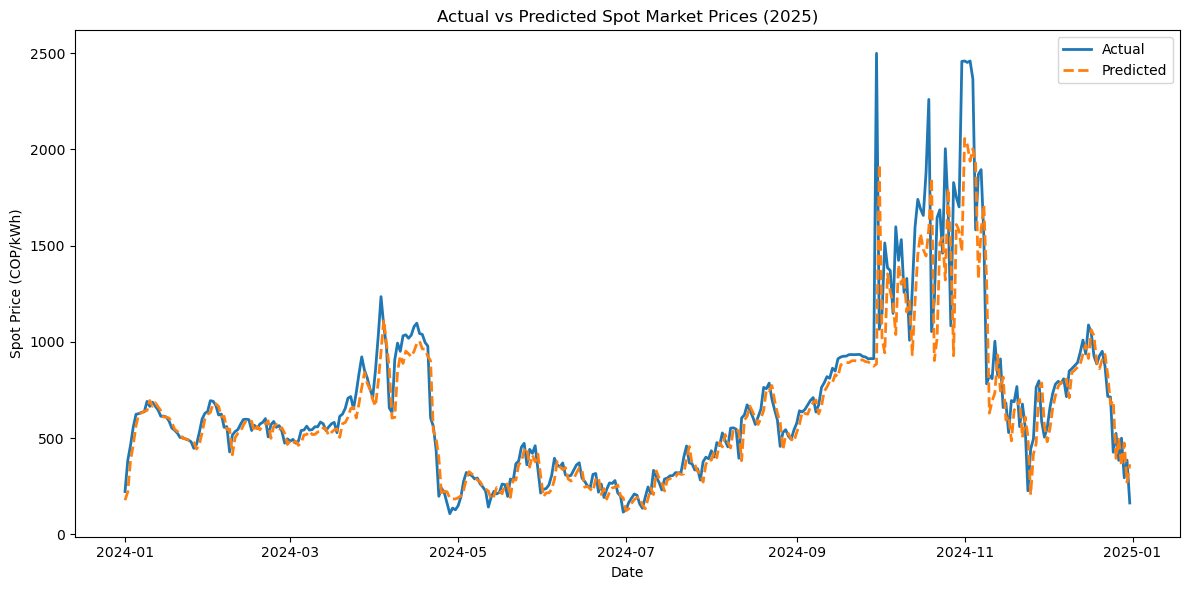

Max Absolute Error: 1613.55


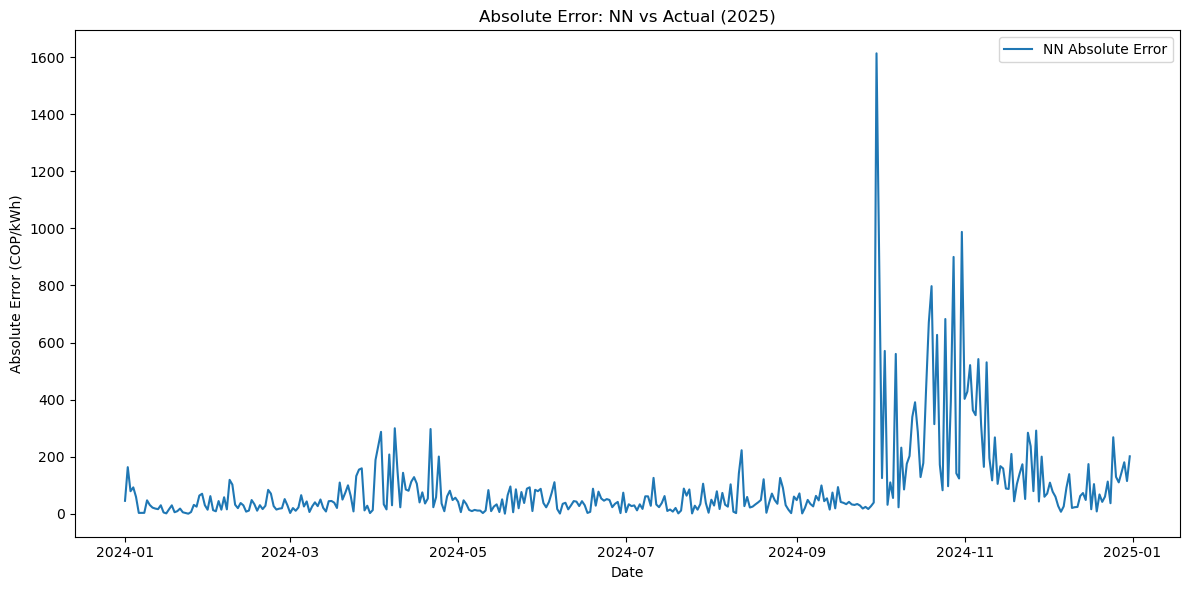

In [40]:
rmse = root_mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Create a time axis using the Row Labels from the test set
test_dates = test_df['Row Labels'].reset_index(drop=True)

# Flatten the arrays
y_actual = y_test_rescaled.flatten()
y_pred = predictions_rescaled.flatten()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_actual, label='Actual', linewidth=2)
plt.plot(test_dates, y_pred, label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Spot Price (COP/kWh)')
plt.title('Actual vs Predicted Spot Market Prices (2025)')
plt.legend()
plt.tight_layout()
plt.show()


# 5) Compute absolute error for NN
abs_error_nn = np.abs(y_actual - y_pred)
print(f'Max Absolute Error: {max(abs_error_nn):.2f}')

# 6) Plot the absolute error over time
plt.figure(figsize=(12, 6))
plt.plot(test_dates, abs_error_nn, label='NN Absolute Error')
plt.legend()
plt.title('Absolute Error: NN vs Actual (2025)')
plt.xlabel('Date')
plt.ylabel('Absolute Error (COP/kWh)')
plt.tight_layout()
plt.show()

# LSTM

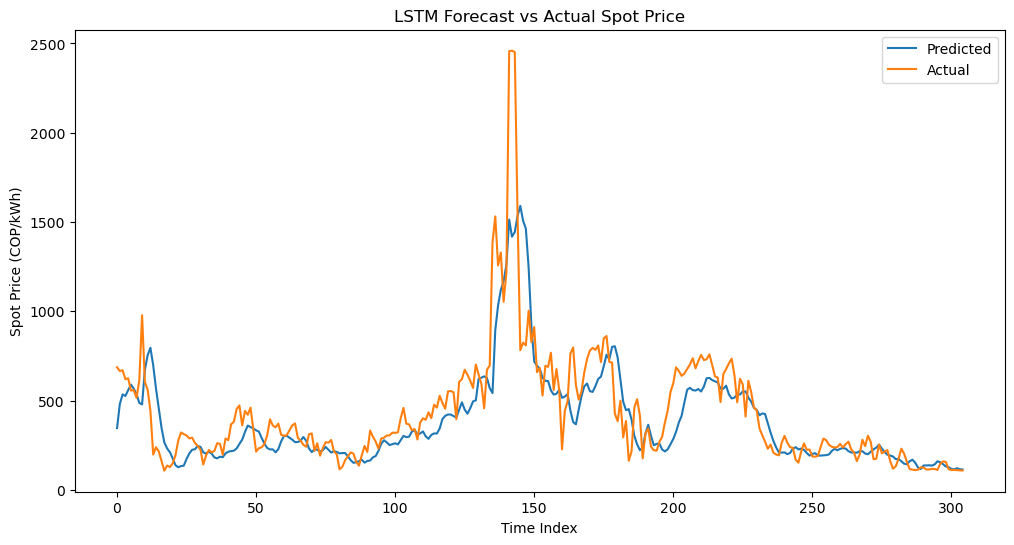

Test RMSE: 185.80 COP/kWh


In [91]:
# Load and preprocess data
df = pd.read_csv("Input Data.csv")
df = df[df['Row Labels'] != 'Grand Total']
df['Row Labels'] = pd.to_datetime(df['Row Labels'])

# Feature engineering
df['reservoir_gwh'] = df['reservoir_gwh'].str.replace(',', '').astype(float)
df['reservoir_inflows_gwh'] = df['reservoir_inflows_gwh'].astype(float)
df['spot_price_copkwh'] = df['spot_price_copkwh'].str.replace(',', '').astype(float)
df['electric_demand'] = df['electric_demand'].astype(float)

# Add calendar features
df['day_of_week'] = df['Row Labels'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df['Row Labels'].dt.month

lags = [2, 3, 4, 7]
# Create lagged features
for lag in lags:
    df[f'spot_lag_{lag}'] = df['spot_price_copkwh'].shift(lag)
    df[f'reservoir_gwh_lag{lag}'] = df['reservoir_gwh'].shift(lag)
    df[f'reservoir_inflows_gwh_lag{lag}'] = df['reservoir_inflows_gwh'].shift(lag)
    df[f'electric_demand_lag{lag}'] = df['electric_demand'].shift(lag)


# Interaction feature
df['weekend_demand_interaction'] = df['is_weekend'] * df['electric_demand']

# Drop NA rows caused by lags
df.dropna(inplace=True)

# Select features and target
features = (
    [f'reservoir_gwh_lag{lag}' for lag in lags] +
    [f'reservoir_inflows_gwh_lag{lag}' for lag in lags] +
    [f'electric_demand_lag{lag}' for lag in lags] +
    ['day_of_week', 'is_weekend', 'month'] +
    [f'spot_lag_{lag}' for lag in lags] +
    ['weekend_demand_interaction']
)


target = 'spot_price_copkwh'

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

# Create sequences
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

# Week Window Size, 7 day rolling window
window_size = 7
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# Train-test split
dates = df['Row Labels'][window_size:].reset_index(drop=True)

# Define splits
X_train = X_seq[(dates.dt.year >= 2017) & (dates.dt.year <= 2022)]
y_train = y_seq[(dates.dt.year >= 2017) & (dates.dt.year <= 2022)]

X_val = X_seq[dates.dt.year == 2023]
y_val = y_seq[dates.dt.year == 2023]

X_test = X_seq[dates.dt.year >= 2024]
y_test = y_seq[dates.dt.year >= 2024]

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Use full val set without batching
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=len(X_val_tensor), shuffle=False)

# Define LSTM model
class LSTMEnergyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMEnergyModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Initialize and train model
model = LSTMEnergyModel(input_dim=len(features), hidden_dim=64, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)  # Halve LR every 10 epochs, maybe unnecessary 

# Training loop
# Play with number of epochs
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_train_loss += loss.item()
    
    scheduler.step()
    # (Optional: add validation tracking here)
    # print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_train_loss / len(train_loader):.4f}")


# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    predictions_rescaled = scaler_y.inverse_transform(predictions)
    y_test_rescaled = scaler_y.inverse_transform(y_test_tensor.numpy())

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions_rescaled, label='Predicted')
plt.plot(y_test_rescaled, label='Actual')
plt.legend()
plt.title('LSTM Forecast vs Actual Spot Price')
plt.xlabel('Time Index')
plt.ylabel('Spot Price (COP/kWh)')
plt.show()


# Remove NaNs before calculating RMSE
mask = ~np.isnan(predictions_rescaled).flatten() & ~np.isnan(y_test_rescaled).flatten()
rmse = root_mean_squared_error(y_test_rescaled[mask], predictions_rescaled[mask])
print(f"Test RMSE: {rmse:.2f} COP/kWh")



In [97]:
from datetime import datetime, timedelta

# Get today's date (Friday)
today = datetime.today()

# Calculate the previous Monday (date - 5 days from Friday)
monday = today - timedelta(days=(today.weekday() - 0))  # 0 is Monday, weekday() gives Monday=0...Sunday=6

# Format the dates as strings
monday_string = monday.strftime("%b %d").lstrip('0')  # %b gives abbreviated month, %d gives day (with leading zero)
today_string = today.strftime("%b %d").lstrip('0')    # Same formatting for today
month_year_string = today.strftime("%B %Y")  # Full month and year


mon_friday = monday_string + " - " + today_string

# Create the dictionary
date_dict = {
    "mon_fri": mon_friday,
    "Month_Year": month_year_string
}






{'monday': 'May 19', 'today': 'May 22', 'Month_Year': 'May 2025'}
{'mon_fri': 'May 19 - May 22', 'Month_Year': 'May 2025'}
